In [ ]:
from huggingface_hub import snapshot_download

snapshot_download(
    repo_id="xingjunm/WildDeepfake",
    repo_type="dataset",
    local_dir="./WildDeepfake"
)

<h2>Build Dataset</h2>

In [17]:


from prepare_data import WildDeepfakePreparator


preparator = WildDeepfakePreparator(
    data_root=DATA_ROOT,
    output_root="./dataset"
)


preparator.select_num = {
    "fake_train": NUM_FAKE_TRAIN,
    "real_train": NUM_REAL_TRAIN,
    "fake_test": NUM_FAKE_TEST,
    "real_test": NUM_REAL_TEST,
}


dataset_info = preparator.run()

Step 1: 选择性解压文件

处理 fake_train...
  找到 592 个压缩文件，选取前 50 个


  解压 fake_train: 100%|██████████| 50/50 [00:00<00:00, 489.48it/s]


  新解压: 0, 跳过(已存在): 50, 失败: 0

处理 real_train...
  找到 371 个压缩文件，选取前 50 个


  解压 real_train: 100%|██████████| 50/50 [00:00<00:00, 588.31it/s]


  新解压: 0, 跳过(已存在): 50, 失败: 0

处理 fake_test...
  找到 115 个压缩文件，选取前 30 个


  解压 fake_test: 100%|██████████| 30/30 [00:00<00:00, 614.26it/s]


  新解压: 0, 跳过(已存在): 30, 失败: 0

处理 real_test...
  找到 42 个压缩文件，选取前 30 个


  解压 real_test: 100%|██████████| 30/30 [00:00<00:00, 602.88it/s]


  新解压: 0, 跳过(已存在): 30, 失败: 0

Step 2: 构建数据集

扫描 fake_train...


  处理 fake_train: 100%|██████████| 166/166 [00:07<00:00, 23.54it/s]



扫描 real_train...


  处理 real_train: 100%|██████████| 150/150 [00:06<00:00, 22.40it/s]



扫描 fake_test...


  处理 fake_test: 100%|██████████| 100/100 [00:03<00:00, 25.59it/s]



扫描 real_test...


  处理 real_test: 100%|██████████| 42/42 [00:02<00:00, 15.18it/s]



数据集统计

train:
  总序列数: 2265
  Real: 1349, Fake: 916
  总帧数: 322329
  平均每序列帧数: 142.3

test:
  总序列数: 762
  Real: 396, Fake: 366
  总帧数: 155914
  平均每序列帧数: 204.6

数据集索引已保存到: dataset/dataset.json


<h2>paramaters</h2>

In [18]:
import torch

DATA_ROOT = "../WildDeepfake"          
DATASET_JSON = "./dataset/dataset.json"  


NUM_FAKE_TRAIN = 50  
NUM_REAL_TRAIN = 50  
NUM_FAKE_TEST = 30   
NUM_REAL_TEST = 30   


MODEL_TYPE = "base"  
PRETRAINED = True    
FREEZE_VIT = False   


NUM_FRAMES = 48      
IMAGE_SIZE = 224     
BATCH_SIZE = 16      
EPOCHS = 10          
LR = 1e-4            
WEIGHT_DECAY = 0.1   
WARMUP_EPOCHS = 3    
NUM_WORKERS = 2      


OUTPUT_DIR = "./checkpoints"


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {DEVICE}")

使用设备: cuda


<h2>check dataset</h2>

In [ ]:
# import json

# # 加载数据集索引
# with open(DATASET_JSON, "r") as f:
#     dataset = json.load(f)

# print("数据集统计:")
# print("=" * 40)

# for split in ["train", "test"]:
#     samples = dataset[split]
#     real_count = sum(1 for s in samples if s["label"] == 0)
#     fake_count = sum(1 for s in samples if s["label"] == 1)
#     total_frames = sum(s["num_frames"] for s in samples)
    
#     print(f"\n{split.upper()}:")
#     print(f"  序列数: {len(samples)}")
#     print(f"  Real: {real_count}, Fake: {fake_count}")
#     print(f"  总帧数: {total_frames}")
#     print(f"  平均帧数: {total_frames / len(samples):.1f}")

In [19]:
import json
from collections import defaultdict
import random

random.seed(42) 


with open(DATASET_JSON, "r") as f:
    dataset = json.load(f)


test_samples = dataset["test"]
print(len(test_samples))

by_label = defaultdict(list)
for s in test_samples:
    by_label[s["label"]].append(s)


val_samples = []
new_test_samples = []

for label, samples in by_label.items():
    random.shuffle(samples)
    split_idx = len(samples) // 2
    val_samples.extend(samples[:split_idx])
    new_test_samples.extend(samples[split_idx:])


dataset["val"] = val_samples
dataset["test"] = new_test_samples


with open(DATASET_JSON, "w") as f:
    json.dump(dataset, f, indent=2)

print("数据集统计:")
print("=" * 40)
for split in ["train", "val", "test"]:
    samples = dataset[split]
    real_count = sum(1 for s in samples if s["label"] == 0)
    fake_count = sum(1 for s in samples if s["label"] == 1)
    total_frames = sum(s["num_frames"] for s in samples)
    
    print(f"\n{split.upper()}:")
    print(f"  序列数: {len(samples)}")
    print(f"  Real: {real_count}, Fake: {fake_count}")
    print(f"  总帧数: {total_frames}")
    print(f"  平均帧数: {total_frames / len(samples):.1f}")


762
数据集统计:

TRAIN:
  序列数: 2265
  Real: 1349, Fake: 916
  总帧数: 322329
  平均帧数: 142.3

VAL:
  序列数: 381
  Real: 198, Fake: 183
  总帧数: 67664
  平均帧数: 177.6

TEST:
  序列数: 381
  Real: 198, Fake: 183
  总帧数: 88250
  平均帧数: 231.6


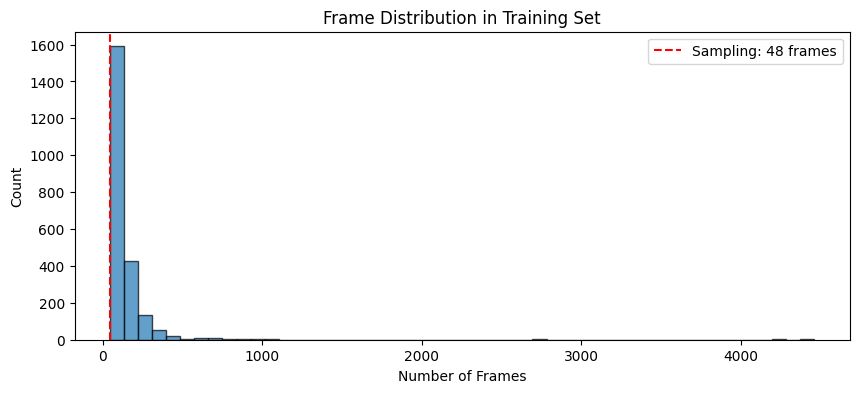

帧数 < 48 的序列: 1


In [20]:

import matplotlib.pyplot as plt

train_frames = [s["num_frames"] for s in dataset["train"]]

plt.figure(figsize=(10, 4))
plt.hist(train_frames, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Number of Frames")
plt.ylabel("Count")
plt.title("Frame Distribution in Training Set")
plt.axvline(x=NUM_FRAMES, color='r', linestyle='--', label=f'Sampling: {NUM_FRAMES} frames')
plt.legend()
plt.show()

print(f"帧数 < {NUM_FRAMES} 的序列: {sum(1 for f in train_frames if f < NUM_FRAMES)}")

<h2>DataLoader</h2>

In [21]:
from deepfake_dataset import create_dataloaders, DeepfakeDataset

# 创建数据加载器
train_loader, test_loader, val_loader = create_dataloaders(
    json_path=DATASET_JSON,
    batch_size=32,
    num_frames=24,
    image_size=IMAGE_SIZE,
    num_workers=NUM_WORKERS,
    sampling="consecutive",
)

print(f"\n训练集 batches: {len(train_loader)}")
print(f"测试集 batches: {len(test_loader)}")
print(f"val batches: {len(val_loader)}")

[train] 加载 2265 个序列 (过滤掉帧数<8的)
[test] 加载 381 个序列 (过滤掉帧数<8的)
[val] 加载 381 个序列 (过滤掉帧数<8的)

训练集 batches: 70
测试集 batches: 12
val batches: 12


In [22]:

videos, labels = next(iter(train_loader))
print(f"Videos shape: {videos.shape}")  # (B, T, C, H, W)
print(f"Labels: {labels}")

Videos shape: torch.Size([32, 24, 3, 224, 224])
Labels: tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0])


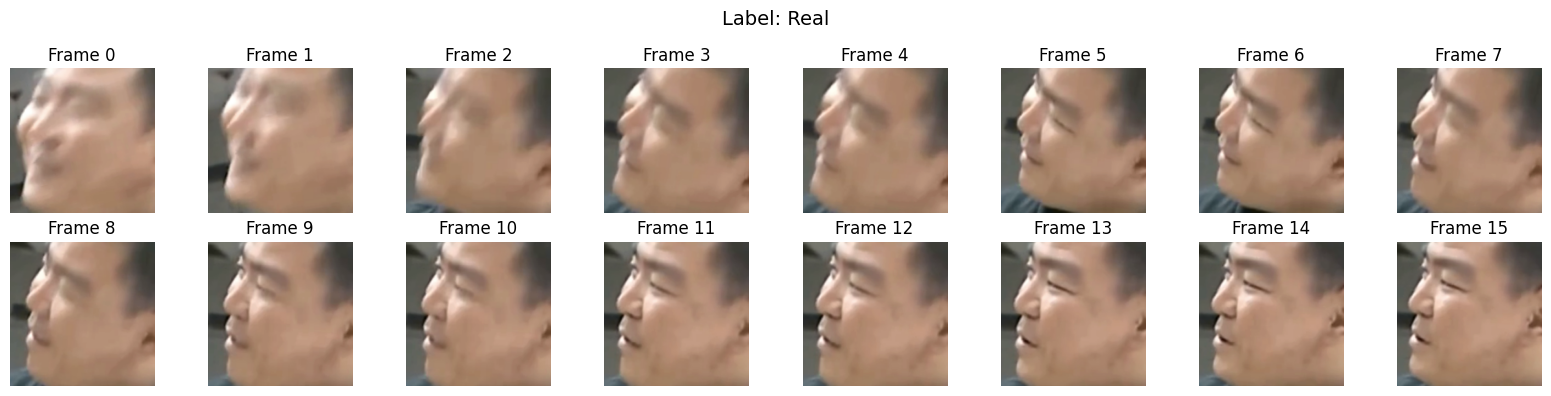

In [23]:

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def denormalize(tensor):

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean


sample_video = videos[0]  # (T, C, H, W)
sample_label = labels[0].item()


fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    if i < len(sample_video):
        img = denormalize(sample_video[i]).permute(1, 2, 0).numpy()
        img = img.clip(0, 1)
        ax.imshow(img)
        ax.set_title(f"Frame {i}")
    ax.axis("off")

plt.suptitle(f"Label: {'Fake' if sample_label == 1 else 'Real'}", fontsize=14)
plt.tight_layout()
plt.show()

<h2>Model</h2>

In [26]:
from model import create_model


model = create_model(
    model_type="lite",
    pretrained=PRETRAINED,
    freeze_vit=False,
    num_classes=2,
    temporal_dropout = 0.3,
    dropout = 0.4,
    temporal_num_heads = 8,
    temporal_num_layers = 4,
)

model = model.to(DEVICE)


创建模型: lite
  ViT: vit_small_patch16_224
  Temporal layers: 4

模型参数统计:
  总参数量: 28.86M
  可训练参数: 28.86M
  特征维度: 384


In [27]:

with torch.no_grad():
    test_input = videos[:2].to(DEVICE)
    test_output = model(test_input)
    print(f"输入: {test_input.shape}")
    print(f"输出: {test_output.shape}")
    print(f"预测: {test_output.argmax(dim=1)}")

输入: torch.Size([2, 24, 3, 224, 224])
输出: torch.Size([2, 2])
预测: tensor([0, 1], device='cuda:0')


<h2>Train</h2>

In [28]:
from train import Trainer


trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=DEVICE,
    output_dir=OUTPUT_DIR,
    lr=3e-5,
    weight_decay=0.1,
    epochs=10,
    warmup_epochs=5,
    use_amp=True,
    # Focal Loss 设置
    loss_type="focal",      
    focal_gamma=2.0,       
    class_weights="balanced",
)


类别分布: Real=1349, Fake=916
类别权重: Real=0.840, Fake=1.236
Loss 类型: focal
Focal Loss gamma=2.0


In [29]:

history = trainer.train()

开始训练
设备: cuda
训练集大小: 2265
测试集大小: 381
Batch size: 32
Epochs: 10
混合精度: True
输出目录: checkpoints


Epoch 1 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.41s/it]


  Real 准确率: 56.57%
  Fake 准确率: 57.92%
  Balanced Acc: 57.24%
  保存最佳模型: checkpoints/best.pth

Epoch 1/10 完成 (329.3s)
  Train Loss: 0.1938, Train Acc: 48.71%
  Test Loss: 0.1730, Test Acc: 57.22%
  Balanced Acc: 57.24% (Best: 57.24%)
------------------------------------------------------------


Epoch 2 [Train]:   0%|          | 0/70 [00:00<?, ?it/s]

警告: 无法加载图片 ../WildDeepfake/deepfake_in_the_wild/fake_train/190/fake/15/3998.png: cannot identify image file '../WildDeepfake/deepfake_in_the_wild/fake_train/190/fake/15/3998.png'


Epoch 2 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.39s/it]


  Real 准确率: 69.19%
  Fake 准确率: 59.56%
  Balanced Acc: 64.38%
  保存最佳模型: checkpoints/best.pth

Epoch 2/10 完成 (326.4s)
  Train Loss: 0.1808, Train Acc: 54.46%
  Test Loss: 0.1665, Test Acc: 64.57%
  Balanced Acc: 64.38% (Best: 64.38%)
------------------------------------------------------------


Epoch 3 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.37s/it]


  Real 准确率: 69.19%
  Fake 准确率: 75.41%
  Balanced Acc: 72.30%
  保存最佳模型: checkpoints/best.pth

Epoch 3/10 完成 (324.5s)
  Train Loss: 0.1561, Train Acc: 67.46%
  Test Loss: 0.1447, Test Acc: 72.18%
  Balanced Acc: 72.30% (Best: 72.30%)
------------------------------------------------------------


Epoch 4 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.33s/it]


  Real 准确率: 73.23%
  Fake 准确率: 77.60%
  Balanced Acc: 75.41%
  保存最佳模型: checkpoints/best.pth

Epoch 4/10 完成 (323.8s)
  Train Loss: 0.1192, Train Acc: 79.02%
  Test Loss: 0.1245, Test Acc: 75.33%
  Balanced Acc: 75.41% (Best: 75.41%)
------------------------------------------------------------


Epoch 5 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.32s/it]


  Real 准确率: 81.82%
  Fake 准确率: 80.87%
  Balanced Acc: 81.35%
  保存最佳模型: checkpoints/best.pth

Epoch 5/10 完成 (320.6s)
  Train Loss: 0.0934, Train Acc: 85.76%
  Test Loss: 0.1156, Test Acc: 81.36%
  Balanced Acc: 81.35% (Best: 81.35%)
------------------------------------------------------------


Epoch 6 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.39s/it]


  Real 准确率: 76.26%
  Fake 准确率: 77.05%
  Balanced Acc: 76.66%

Epoch 6/10 完成 (317.8s)
  Train Loss: 0.0699, Train Acc: 88.75%
  Test Loss: 0.1329, Test Acc: 76.64%
  Balanced Acc: 76.66% (Best: 81.35%)
------------------------------------------------------------


Epoch 7 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.34s/it]


  Real 准确率: 94.95%
  Fake 准确率: 55.19%
  Balanced Acc: 75.07%

Epoch 7/10 完成 (318.3s)
  Train Loss: 0.0591, Train Acc: 90.62%
  Test Loss: 0.2439, Test Acc: 75.85%
  Balanced Acc: 75.07% (Best: 81.35%)
------------------------------------------------------------


Epoch 8 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.32s/it]


  Real 准确率: 93.94%
  Fake 准确率: 58.47%
  Balanced Acc: 76.20%

Epoch 8/10 完成 (321.0s)
  Train Loss: 0.0394, Train Acc: 94.64%
  Test Loss: 0.2671, Test Acc: 76.90%
  Balanced Acc: 76.20% (Best: 81.35%)
------------------------------------------------------------


Epoch 9 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.28s/it]


  Real 准确率: 90.40%
  Fake 准确率: 71.58%
  Balanced Acc: 80.99%

Epoch 9/10 完成 (318.1s)
  Train Loss: 0.0289, Train Acc: 96.52%
  Test Loss: 0.2161, Test Acc: 81.36%
  Balanced Acc: 80.99% (Best: 81.35%)
------------------------------------------------------------


Epoch 10 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.33s/it]


  Real 准确率: 90.91%
  Fake 准确率: 69.95%
  Balanced Acc: 80.43%

Epoch 10/10 完成 (318.3s)
  Train Loss: 0.0236, Train Acc: 96.92%
  Test Loss: 0.2266, Test Acc: 80.84%
  Balanced Acc: 80.43% (Best: 81.35%)
------------------------------------------------------------

训练完成！总耗时: 0.89小时
最佳 Balanced Accuracy: 81.35%


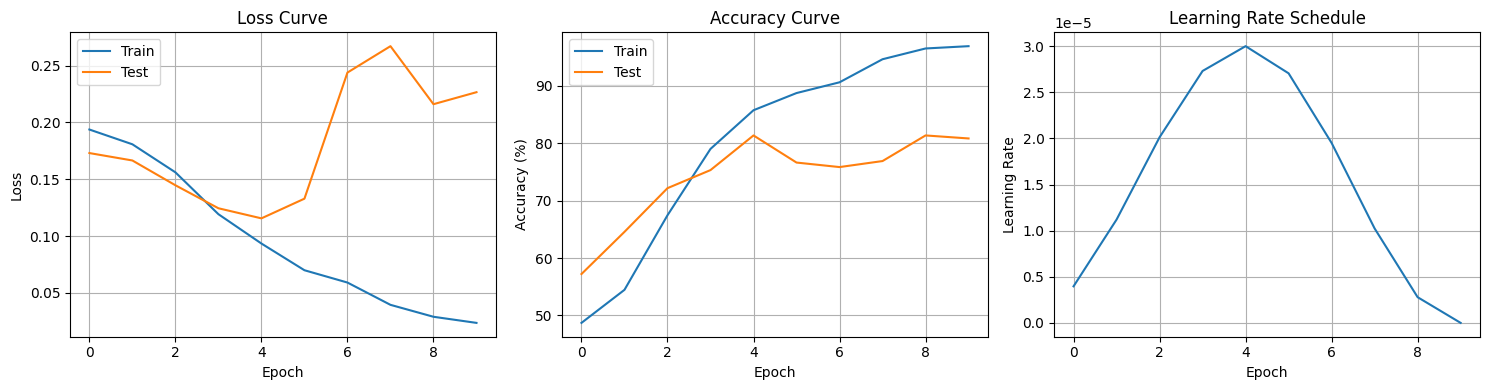


最佳测试准确率: 81.36%


In [30]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))


axes[0].plot(history["train_loss"], label="Train")
axes[0].plot(history["test_loss"], label="Test")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Curve")
axes[0].legend()
axes[0].grid(True)


axes[1].plot(history["train_acc"], label="Train")
axes[1].plot(history["test_acc"], label="Test")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Accuracy Curve")
axes[1].legend()
axes[1].grid(True)


axes[2].plot(history["lr"])
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Learning Rate")
axes[2].set_title("Learning Rate Schedule")
axes[2].grid(True)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/training_curves.png", dpi=150)
plt.show()

print(f"\n最佳测试准确率: {max(history['test_acc']):.2f}%")

In [31]:

best_checkpoint = torch.load(f"{OUTPUT_DIR}/best.pth", map_location=DEVICE)
model.load_state_dict(best_checkpoint["model_state_dict"])
print(f"加载最佳模型，来自 Epoch {best_checkpoint['epoch'] + 1}")


加载最佳模型，来自 Epoch 5


分类报告:
              precision    recall  f1-score   support

        Real       0.78      0.78      0.78       198
        Fake       0.77      0.77      0.77       183

    accuracy                           0.77       381
   macro avg       0.77      0.77      0.77       381
weighted avg       0.77      0.77      0.77       381



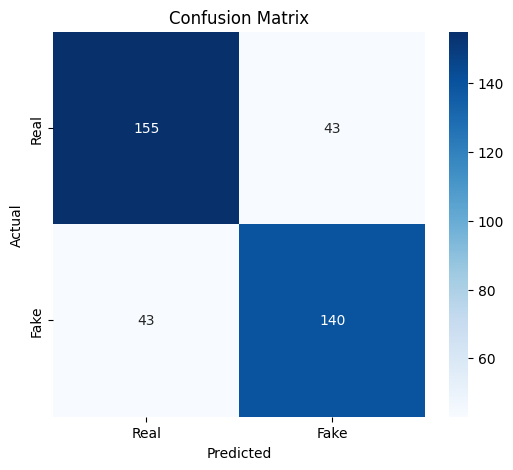

In [32]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in val_loader:
        videos = videos.to(DEVICE)
        outputs = model(videos)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())


print("分类报告:")
print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png", dpi=150)
plt.show()

In [34]:
import numpy as np
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

overall_acc = (all_preds == all_labels).mean() * 100
print(f"\nVAL Overall Accuracy: {overall_acc:.2f}%  ({(all_preds==all_labels).sum()}/{len(all_labels)})")



VAL Overall Accuracy: 77.43%  (295/381)
